In [1]:
import pandas as pd
import re
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

In [2]:
def fft_calc(time, signal, plot=True):
    time = np.array(time)
    signal = np.array(signal)

    dt = np.mean(np.diff(time))    
    T_total = time[-1] - time[0]    
    fs = 1.0 / dt                  
    N = len(time)                

    # Remove DC (detrend)
    signal = signal - np.mean(signal)

    fft_vals = fft(signal)
    freqs = fftfreq(N, d=dt)

    # Keep only positive frequencies
    mask = freqs > 0
    freqs = freqs[mask]
    fft_power = np.abs(fft_vals[mask])**2
    
    return freqs, fft_power

In [3]:
input_file = "wan.txt"
output_dir = "runs_csv"

os.makedirs(output_dir, exist_ok=True)

with open(input_file, "r") as f:
    lines = f.readlines()

runs = {}
current_run = None
header = None
data_rows = []

for line in lines:
    line = line.strip()
    
    run_match = re.match(r"Run (\d+)", line)
    if run_match:
        if current_run is not None and header and data_rows:
            df = pd.DataFrame(data_rows, columns=header)
            runs[current_run] = df
            data_rows = []
        
        current_run = int(run_match.group(1))
        continue
    
    if line.startswith("Time"):
        header = line.split("\\t")
        continue
    
    if line.startswith("T") or line.startswith("s") or not line:
        continue
    
    if header and (line[0].isdigit() or line.startswith("0")):
        values = line.split("\\t")
        data_rows.append(values)

if current_run is not None and header and data_rows:
    df = pd.DataFrame(data_rows, columns=header)
    runs[current_run] = df

for run_number, df in runs.items():
    filename = os.path.join(output_dir, f"Run_{run_number}.csv")
    df.to_csv(filename, index=False)

print(f"Saved {len(runs)} runs into '{output_dir}/Run_X.csv' files")

Saved 17 runs into 'runs_csv/Run_X.csv' files


In [5]:
### Experimental Data

# Base Configuration
m1 = 4.027
m2 = 4.018
L1 = 115
L2 = 115.2
# l1 = ?
# l2 = ?

## Spring Constant

In [6]:
# (kg, cm)
spring_data = [
    (0.019, 13.5),
    (0.049, 14.5),
    (0.1, 16.5),
    (0.199, 20.5),
    (0.497, 32)
]
g = 9.81
spring_l0 = 12.5

Hooke's Law
$$ F = kx $$
$$ mg = kx $$

<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:63: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:63: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_25209/1021521698.py:62: SyntaxWarning: invalid escape sequence '\p'
  f"$k = {k:.2f} \pm {sigma_k:.2f}$ N/m\n"
/tmp/ipykernel_25209/1021521698.py:63: SyntaxWarning: invalid escape sequence '\p'
  f"$F_0 = {F0:.2f} \pm {sigma_F0:.2f}$ N",


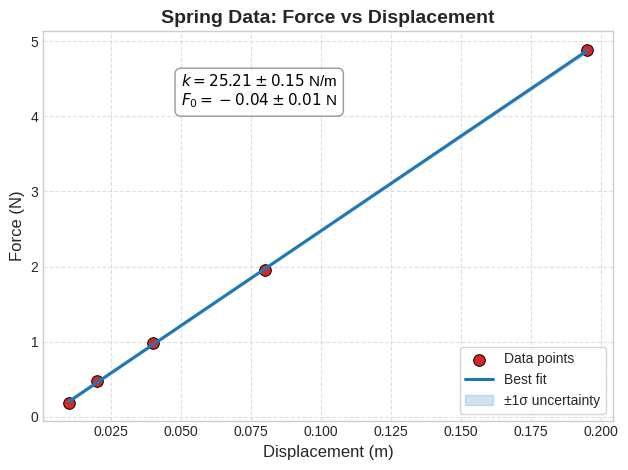

In [23]:
# plot and fit
y = np.array([d[0]*g for d in spring_data])  # Force (N)
x = np.array([(d[1]-spring_l0)/100 for d in spring_data])  # Displacement

# define linear model: Hooke's law F = kx + F0 (maybe offset)
def linear_model(x, k, F0):
    return k * x + F0

# fit model
params, covariance = curve_fit(linear_model, x, y)
k, F0 = params
perr = np.sqrt(np.diag(covariance))  # standard errors of k and F0

sigma_k, sigma_F0 = perr
cov_kF0 = covariance[0, 1]

x_fit = np.linspace(min(x), max(x), 200)
y_sigma = np.sqrt(
    (x_fit**2) * sigma_k**2 +
    sigma_F0**2 +
    2 * x_fit * cov_kF0
)

y_fit = linear_model(x_fit, k, F0)

# # Plot data, fit, and confidence band
# plt.scatter(x, y, color="red", label="Data points")
# plt.plot(x_fit, y_fit, color="blue", label=f"Fit: F={k:.2f}x+{F0:.2f}")
# plt.fill_between(x_fit, y_fit - y_sigma, y_fit + y_sigma,
#                  color="blue", alpha=0.2, label="±1σ uncertainty")

# plt.xlabel("Displacement (m)")
# plt.ylabel("Force (N)")
# plt.title("Spring Data: Force vs Displacement with Uncertainty")
# plt.legend()
# plt.grid(True)
# plt.show()

# print(f"Spring constant k = {k:.3f} ± {sigma_k:.3f} N/m")
# print(f"Offset F0 = {F0:.3f} ± {sigma_F0:.3f} N")
# Plot data, fit, and confidence band
plt.style.use("seaborn-v0_8-whitegrid")

# Plot data points
plt.scatter(x, y, 
            color="#d62728", s=70, marker="o", 
            edgecolor="black", linewidth=0.7, 
            label="Data points")

# Plot fit line
plt.plot(x_fit, y_fit, 
         color="#1f77b4", linewidth=2.2, 
         label="Best fit")

# Plot uncertainty band
plt.fill_between(x_fit, y_fit - y_sigma, y_fit + y_sigma,
                 color="#1f77b4", alpha=0.2, 
                 label="±1σ uncertainty")

# Annotation box with spring constant and offset
plt.text(0.05, max(y)*0.85,
         f"$k = {k:.2f} \pm {sigma_k:.2f}$ N/m\n"
         f"$F_0 = {F0:.2f} \pm {sigma_F0:.2f}$ N",
         fontsize=11, color="black",
         bbox=dict(boxstyle="round,pad=0.4", 
                   facecolor="white", alpha=0.8, 
                   edgecolor="gray"))

# Labels and title
plt.xlabel("Displacement (m)", fontsize=12)
plt.ylabel("Force (N)", fontsize=12)
plt.title("Spring Data: Force vs Displacement", fontsize=14, weight="bold")

# Legend
plt.legend(frameon=True, fontsize=10, loc="lower right")

# Grid and layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("plots/SpringConstant.pdf")
plt.show()

## Vernier Data

In [13]:
# Data Labels
data_titles = {
    "Run 2":"Symmetric base (at rest)",
    "Run 4":"Symmetric base (In Phase)",
    "Run 5":"Symmetric base (Out of Phase)",
    "Run 6":"Symmetric base (Beat)",
    "Run 7":"Length Variation (at rest)",
    "Run 8":"Length Variation (In Phase)",
    "Run 9":"Length Variation (Out of Phase)",
    "Run 10":"Length Variation (Beat mode 1)",
    "Run 11":"Length Variation (Beat mode 2)",
    "Run 12":"Mass Variation (at rest)",
    "Run 13":"Mass Variation (In Phase)",
    "Run 14":"Mass Variation (Out of Phase)",
    "Run 16":"Mass Variation (Beat mode 1)",
    "Run 17":"Mass Variation (Beat mode 2)"
}

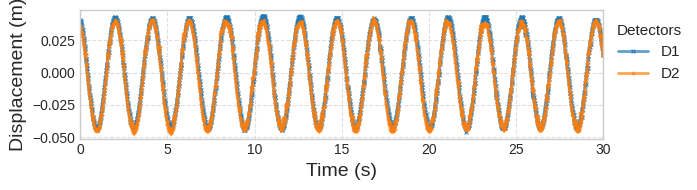

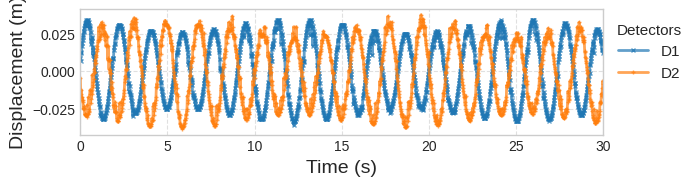

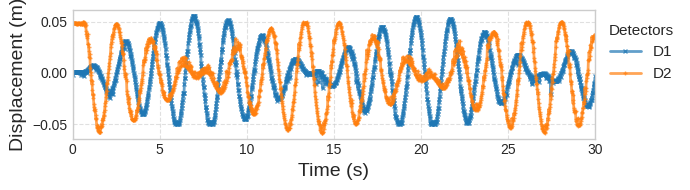

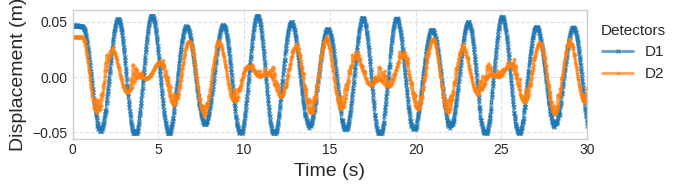

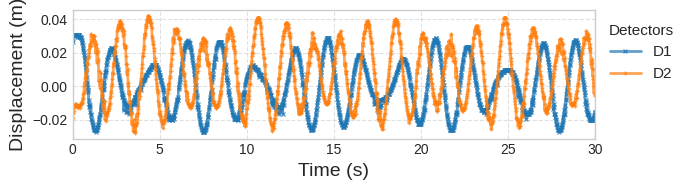

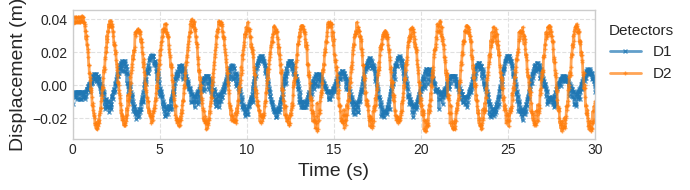

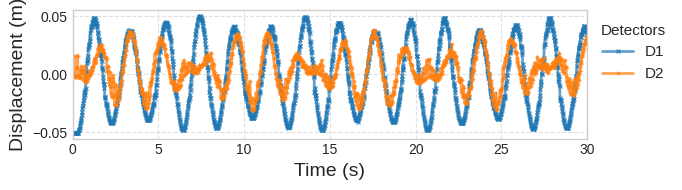

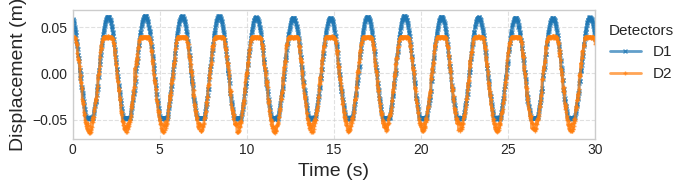

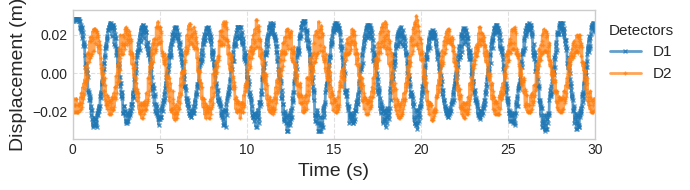

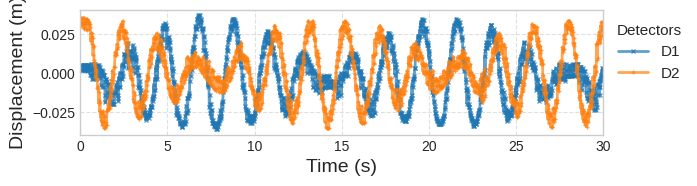

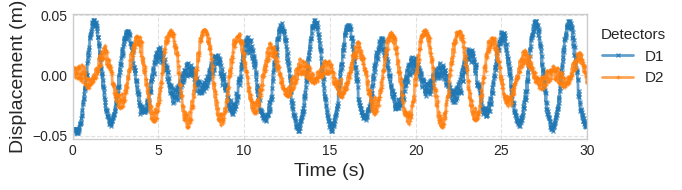

In [34]:
rest_runs = [2, 7, 12]
rest_positions = {}

# First, extract rest positions from rest runs
for i in rest_runs:
    df_rest = pd.read_csv(f"runs_csv/Run_{i}.csv", sep="\t")
    df_rest = df_rest.apply(pd.to_numeric)

    # take initial position values (first row)
    rest_positions[i] = {
        "D1": np.mean(df_rest["Position"]),
        "D2": np.mean(df_rest["Position.1"]),
    }

for i in [4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17]:
    df = pd.read_csv(f"runs_csv/Run_{i}.csv", sep="\t")
    df = df.apply(pd.to_numeric)

    # Find which rest run applies for this run
    # (if i itself is a rest run, just use its own baseline)
    if i in [4, 5, 6]:
        rest_key = 2
    elif i in [8, 9, 10, 11]:
        rest_key = 7
    else:
        rest_key = 12
    time_min, time_max = df["Time"].min(), df["Time"].max()
    half_time = time_min + 0.5 * (time_max - time_min)
    # Subtract baseline positions
    df["Position_norm"] = df["Position"] - rest_positions[rest_key]["D1"]
    df["Position.1_norm"] = -df["Position.1"] + rest_positions[rest_key]["D2"]

    # Plot
    plt.figure(figsize=(7,2))
    plt.plot(df["Time"], df["Position_norm"], label="D1", linewidth=2, marker="x", markersize=3, alpha=0.7)
    plt.plot(df["Time"], df["Position.1_norm"], label="D2", linewidth=2, marker="+", markersize=3, alpha=0.7)

    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Displacement (m)", fontsize=14)
#     plt.title(f"{data_titles[f'Run {i}']}", fontsize=14, fontweight="bold")

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Detectors", fontsize=11, title_fontsize=11, loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.xlim(time_min, half_time)
    plt.savefig(f"plots/{data_titles[f'Run {i}']}_pos_30sec.pdf")
    plt.show()


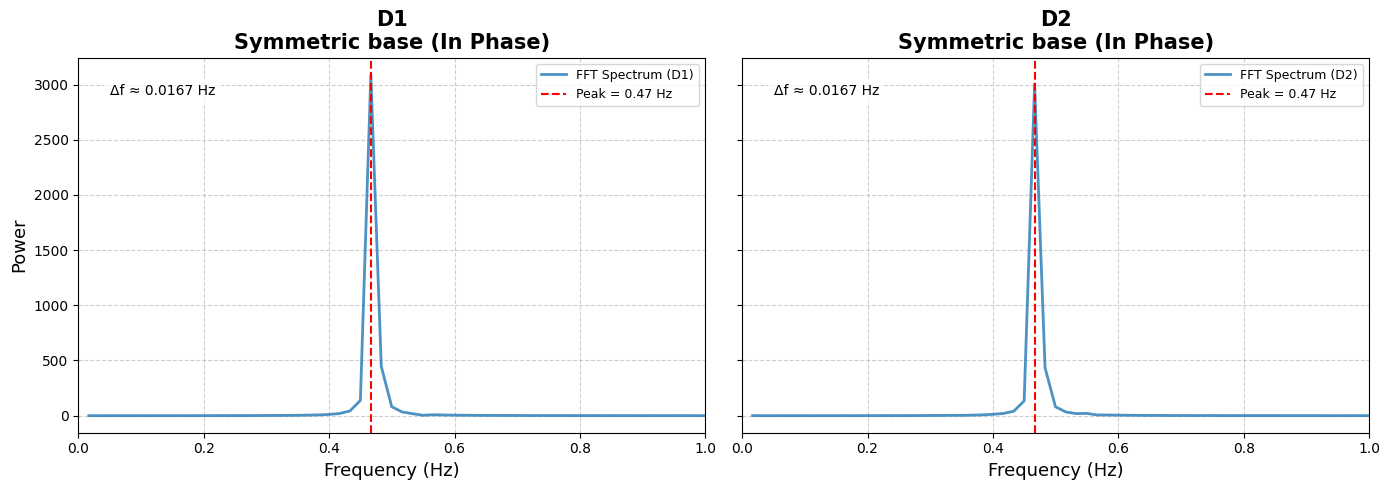

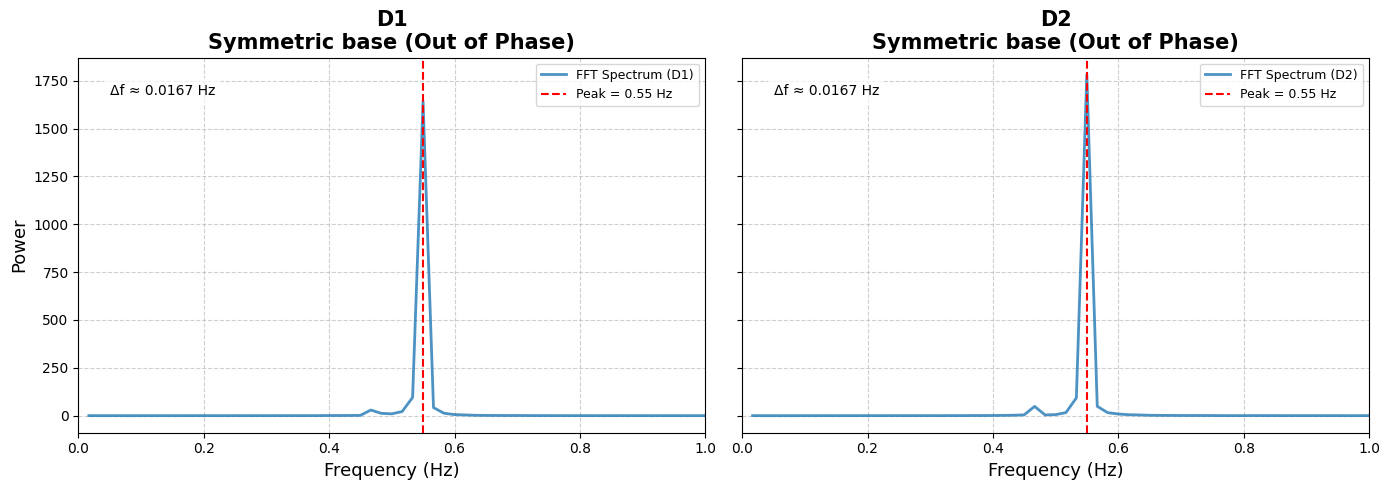

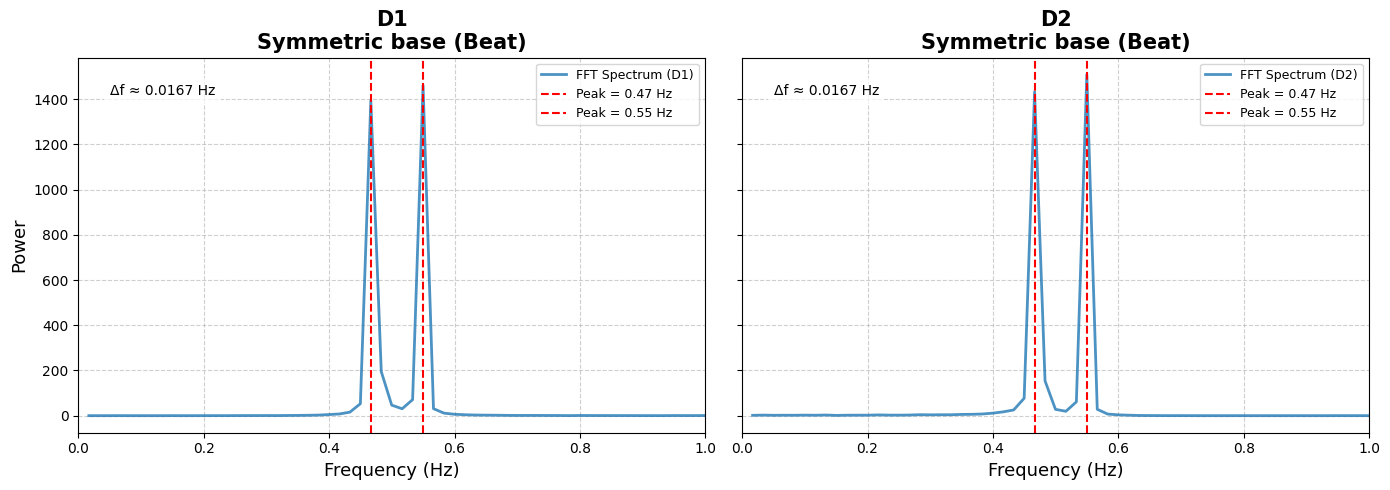

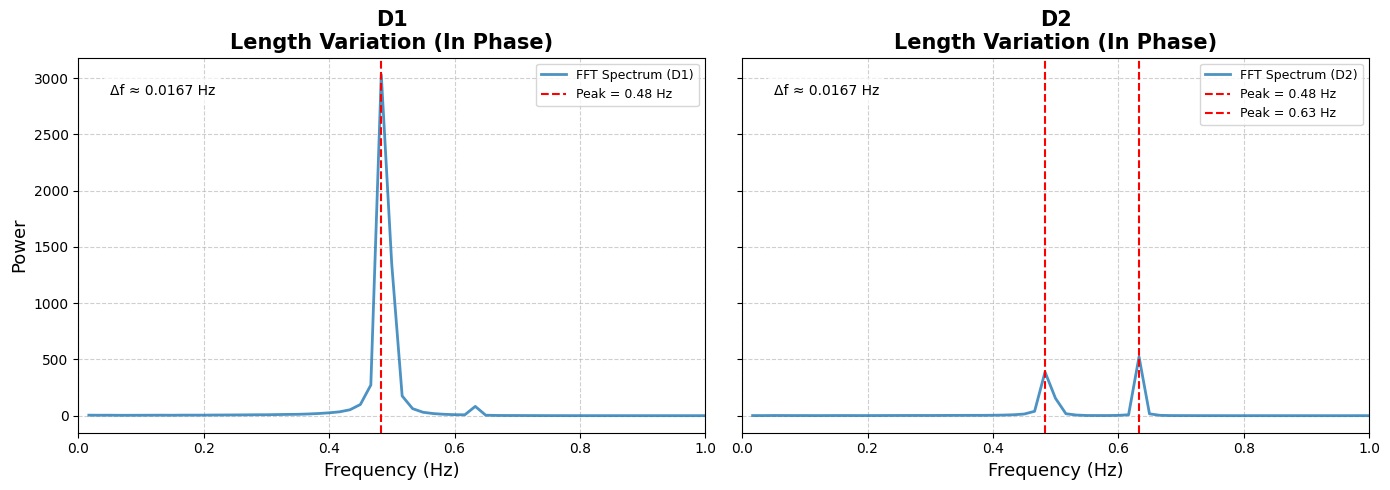

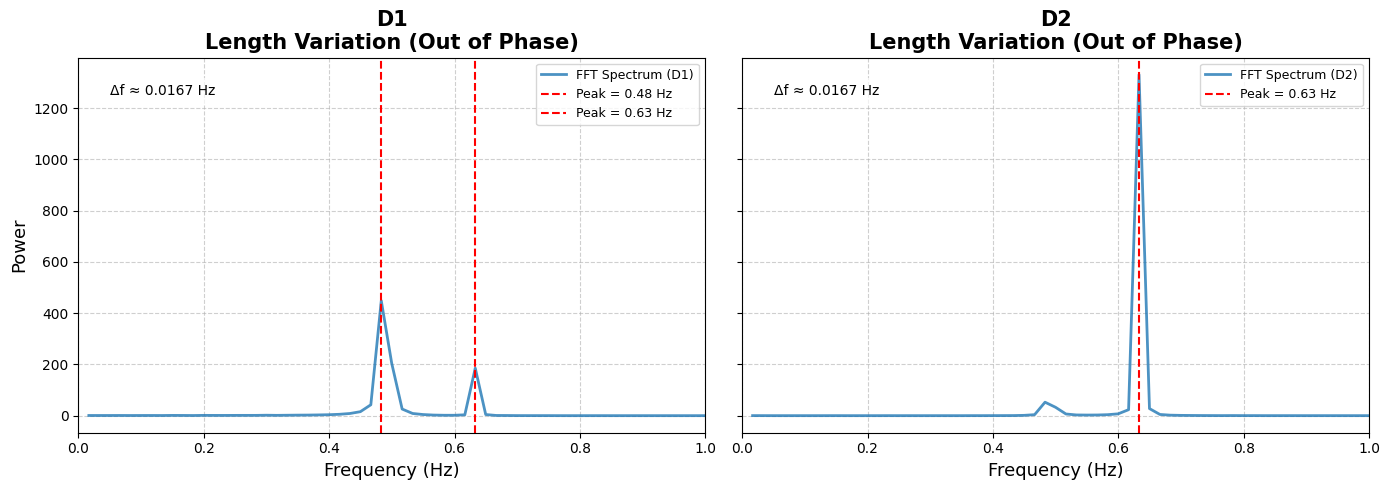

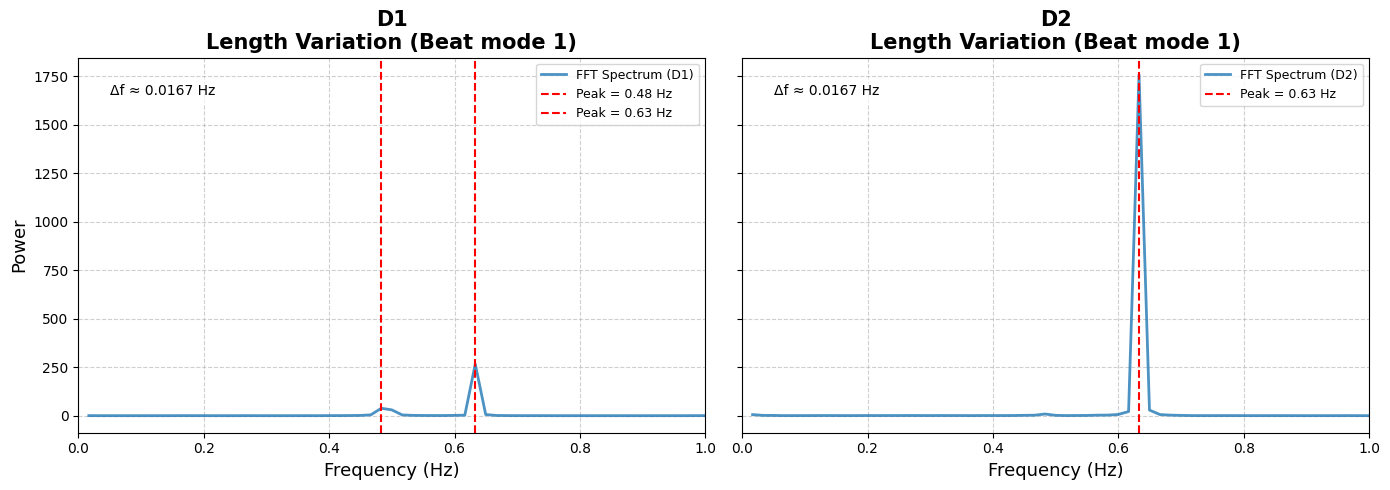

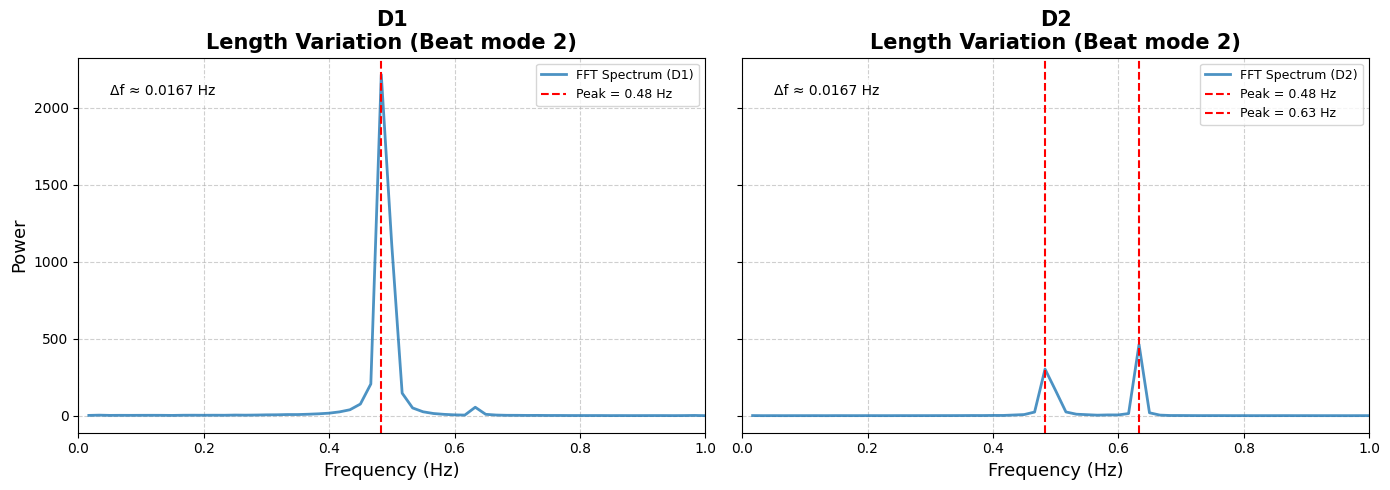

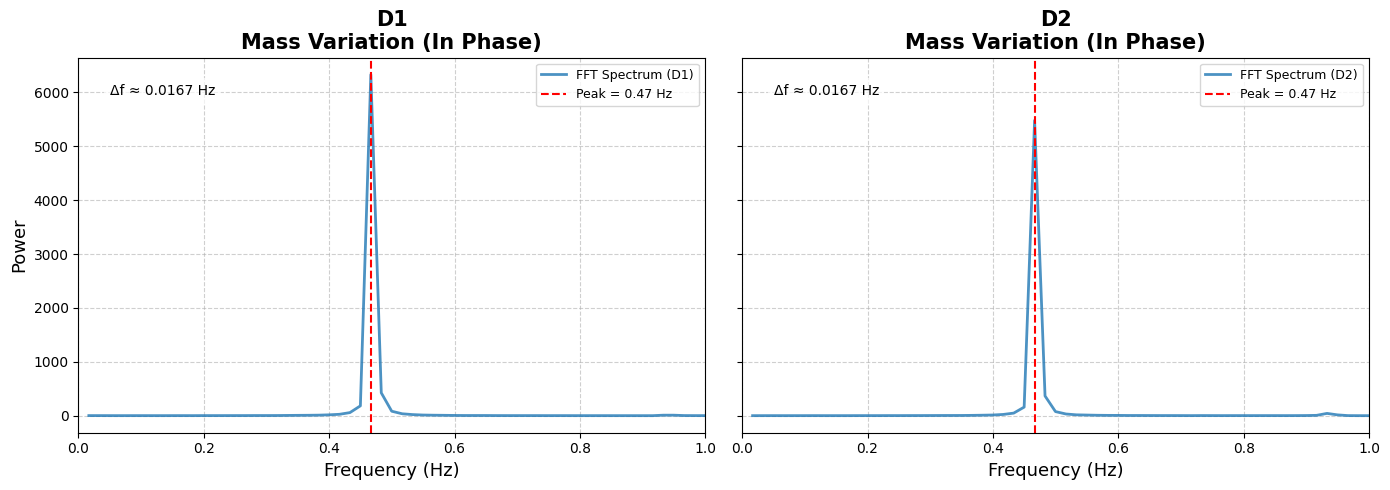

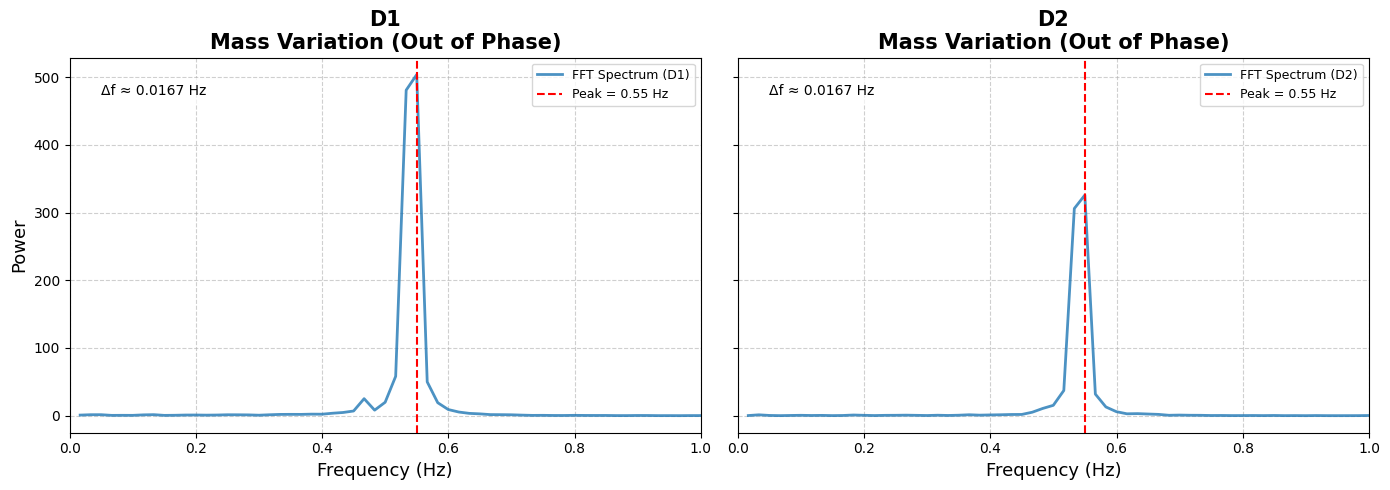

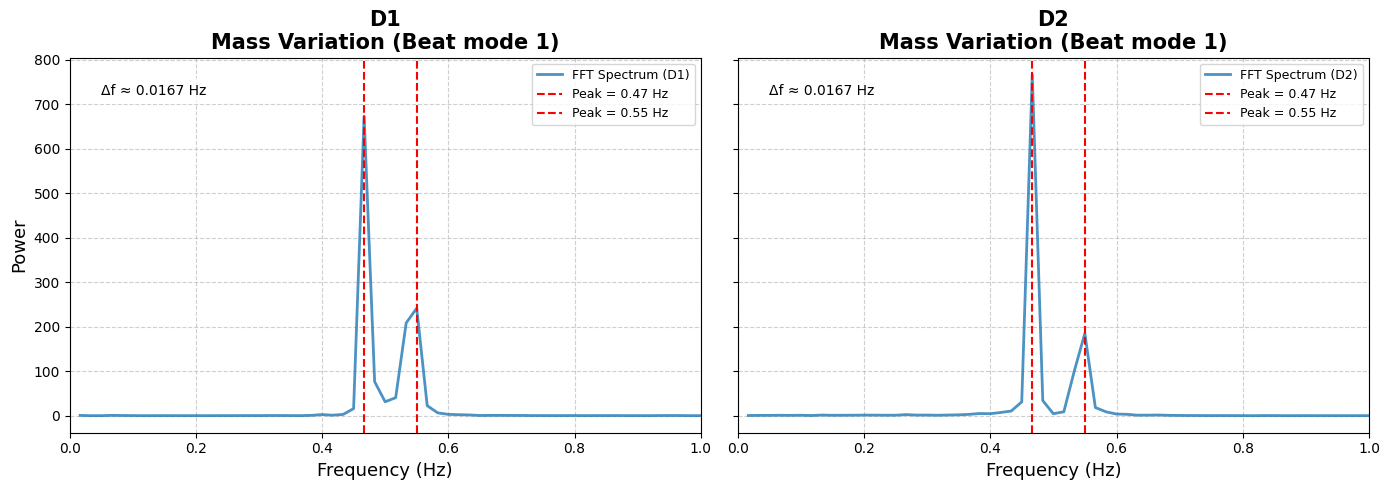

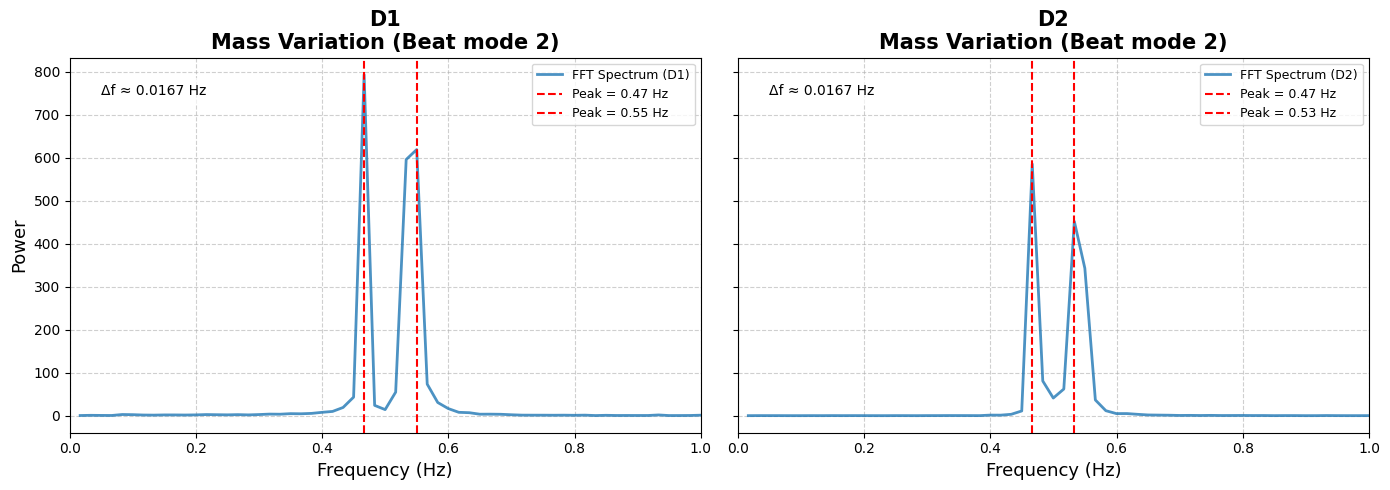

In [19]:
for i in [4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17]:
    df = pd.read_csv(f"runs_csv/Run_{i}.csv", sep="\t")
    df = df.apply(pd.to_numeric)

    if i in [4, 5, 6]:
        rest_key = 2
    elif i in [8, 9, 10, 11]:
        rest_key = 7
    else:
        rest_key = 12

    d1 = df["Position"].values - rest_positions[rest_key]["D1"]
    d2 = -df["Position.1"].values + rest_positions[rest_key]["D2"]
    time = df["Time"].values

    d1_freq, d1_power = fft_calc(time, d1)
    d2_freq, d2_power = fft_calc(time, d2)

    peak_idx_d1, _ = find_peaks(d1_power, height=np.max(d1_power) * 0.1)
    peak_idx_d2, _ = find_peaks(d2_power, height=np.max(d2_power) * 0.1)

    dom_freqs_d1 = d1_freq[peak_idx_d1]
    dom_freqs_d2 = d2_freq[peak_idx_d2]

    # Frequency resolution
    T_total = time[-1] - time[0]
    freq_uncertainty = 1.0 / T_total

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    plot_kwargs = dict(linewidth=2, alpha=0.8)

    # Left plot (D1)
    axes[0].plot(d1_freq, d1_power, **plot_kwargs, label="FFT Spectrum (D1)")
    for f in dom_freqs_d1:
        axes[0].axvline(f, color="r", linestyle="--", linewidth=1.5,
                        label=f"Peak = {f:.2f} Hz")
    axes[0].set_xlabel("Frequency (Hz)", fontsize=13)
    axes[0].set_ylabel("Power", fontsize=13)
    axes[0].set_title(f"D1\n{data_titles[f'Run {i}']}",
                      fontsize=15, fontweight="bold")
    axes[0].legend(fontsize=9, loc="upper right")
    axes[0].grid(True, linestyle="--", alpha=0.6)
    axes[0].set_xlim(0, 1)
    axes[0].text(0.05, 0.9, f"Δf ≈ {freq_uncertainty:.4f} Hz",
                 transform=axes[0].transAxes, fontsize=10,
                 bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    # Right plot (D2)
    axes[1].plot(d2_freq, d2_power, **plot_kwargs, label="FFT Spectrum (D2)")
    for f in dom_freqs_d2:
        axes[1].axvline(f, color="r", linestyle="--", linewidth=1.5,
                        label=f"Peak = {f:.2f} Hz")
    axes[1].set_xlabel("Frequency (Hz)", fontsize=13)
    axes[1].set_title(f"D2\n{data_titles[f'Run {i}']}",
                      fontsize=15, fontweight="bold")
    axes[1].legend(fontsize=9, loc="upper right")
    axes[1].grid(True, linestyle="--", alpha=0.6)
    axes[1].set_xlim(0, 1)
    axes[1].text(0.05, 0.9, f"Δf ≈ {freq_uncertainty:.4f} Hz",
                 transform=axes[1].transAxes, fontsize=10,
                 bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
    
    plt.tight_layout()
    plt.savefig(f"plots/{data_titles[f'Run {i}']}_fft.pdf")
    plt.show()

In [16]:
results = []

for i in [4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17]:
    df = pd.read_csv(f"runs_csv/Run_{i}.csv", sep="\t").apply(pd.to_numeric)

    if i in [4, 5, 6]:
        rest_key = 2
    elif i in [8, 9, 10, 11]:
        rest_key = 7
    else:
        rest_key = 12

    d1 = df["Position"].values - rest_positions[rest_key]["D1"]
    d2 = -df["Position.1"].values + rest_positions[rest_key]["D2"]
    time = df["Time"].values

    d1_freq, d1_power = fft_calc(time, d1)
    d2_freq, d2_power = fft_calc(time, d2)

    peaks_d1, _ = find_peaks(d1_power, height=np.max(d1_power) * 0.1)
    peaks_d2, _ = find_peaks(d2_power, height=np.max(d2_power) * 0.1)

    dom_freqs = np.unique(np.round(np.concatenate([
        d1_freq[peaks_d1], d2_freq[peaks_d2]
    ]), 3))

    results.append({
        "Run": i,
        "Description": data_titles[f"Run {i}"],
        "Frequencies (Hz)": dom_freqs.tolist()
    })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


    Run                      Description      Frequencies (Hz)
0     4        Symmetric base (In Phase)               [0.467]
1     5    Symmetric base (Out of Phase)                [0.55]
2     6            Symmetric base (Beat)         [0.467, 0.55]
3     8      Length Variation (In Phase)        [0.483, 0.633]
4     9  Length Variation (Out of Phase)        [0.483, 0.633]
5    10   Length Variation (Beat mode 1)        [0.483, 0.633]
6    11   Length Variation (Beat mode 2)        [0.483, 0.633]
7    13        Mass Variation (In Phase)               [0.467]
8    14    Mass Variation (Out of Phase)                [0.55]
9    16     Mass Variation (Beat mode 1)         [0.467, 0.55]
10   17     Mass Variation (Beat mode 2)  [0.467, 0.533, 0.55]
